### Adaptive RAG

Adaptive RAG is a framework that dynamically adjusts its strategy for handling queries based on their complexity. Its like having a smart assistant that knows when to dig deep for information and when to provide a simple answer. Instead of using a single, rigid approach, Adaptive RAG chooses the most appropriate retrieval method for each query, balancing speed and accuracy.


In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.embeddings import OllamaEmbeddings
from langchain_core.prompts import ChatPromptTemplate
from langchain_groq import ChatGroq
from pydantic import Field, BaseModel
#from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from typing import List, Literal
from typing_extensions import TypedDict
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.documents import Document
from langgraph.graph import END, START, StateGraph
from IPython.display import Image, display
from langchain_core.prompts import PromptTemplate

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [2]:
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")
embeddings = OllamaEmbeddings(model="mxbai-embed-large")

C:\Users\Admin\AppData\Local\Temp\ipykernel_8280\2376517371.py:3: LangChainDeprecationWarning: The class `OllamaEmbeddings` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the `langchain-ollama package and should be used instead. To use it run `pip install -U `langchain-ollama` and import as `from `langchain_ollama import OllamaEmbeddings``.
  embeddings = OllamaEmbeddings(model="mxbai-embed-large")


In [3]:
## Dos to index
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/"
]

## lOAD
docs  = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

### Split
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size =500, chunk_overlap =20
)
doc_splits = text_splitter.split_documents(docs_list)

## Add to vetorstore
vectorestore = FAISS.from_documents(
    documents = doc_splits,
    embedding = OllamaEmbeddings(model="mxbai-embed-large")
)

retriever = vectorestore.as_retriever()


In [18]:
# Data Model
class RouteQuery(BaseModel):
    """ Route a user query to the most relevant datasource """

    datasource: Literal["vectorstore","web_search"] = Field(
        ...,
        description = "Given a user question choose to route it to web search or a vectorstore",
    )

### LLM with function call
llm = ChatGroq(model="qwen/qwen3-32b")
structured_llm_router = llm.with_structured_output(RouteQuery)

## Define Prompt
system = """ You are an expert at routing a user question to a vectorstore or web search.
The vectorstore contains documents related to agents, prompt engineering, and adversarial attacks.
Use the vectorstore for questions on these topics. Otherwise, use web-search."""
route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

### question_router
question_router = route_prompt | structured_llm_router

print(
    question_router.invoke(
        {"question":"who won the cricket world cup 2023"}
    )
)

datasource='web_search'


In [19]:
print(
    question_router.invoke(
        {"question":"what are the types of agent memory"}
    )
)

datasource='vectorstore'


In [20]:
# Data Model
class GradeDocuments(BaseModel):
    """ Binary score for relevance check on retrieved documents."""

    binar_score:str = Field(
        description= "Documents are relevant to the question, 'yes' or 'no'"
    )

## LLM with function call
llm = ChatGroq(model="qwen/qwen3-32b")
structured_llm_grader = llm.with_structured_output(GradeDocuments)

## Prompt
system = """ You are a grader assessing relevance of a retrieved document to a user question. \n
 If the document contins keyword(s) or semantic meaning related to the question, grade it as relevant. \n
 Give a binary score 'yes'or 'no' to indicate whether the document is relevant to the question."""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),

    ]
 )

 ## Chain
retrieval_grader = grade_prompt | structured_llm_grader
question= "agent memory"
docs = retriever.invoke(question)
doc_txt = docs[1].page_content
score = retrieval_grader.invoke({"question": question, "document": doc_txt})
print(score)

binar_score='yes'


In [21]:
## Generate

prompt = PromptTemplate(
    input_variables=["context", "question"],
    template="""
You are an expert assistant. Use ONLY the following context to answer.

Context:
{context}

Question:
{question}

Answer in a clear, concise, and helpful way.
""",
)


##LLM
llm = ChatGroq(model="qwen/qwen3-32b")

## post processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

## Chain
rag_chain = prompt | llm | StrOutputParser()

## Run
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)

<think>
Okay, so the user is asking about "agent memory" in the context of LLM-powered autonomous agents. Let me start by recalling the information from the provided documents. 

First, the documents mention that memory in these agents is divided into short-term and long-term. Short-term memory is related to in-context learning, which I think refers to the model's ability to use the current input context without external storage. Long-term memory, on the other hand, uses external vector stores for retaining information over extended periods. 

The key components under memory are Short-term memory and Long-term memory. Short-term is about in-context learning, which probably means using the current conversation or task context. Long-term memory uses external storage, like a vector database, for retrieving information when needed.

Also, there's a part about retrieval mechanisms—relevance, recency, and importance. The agent needs to determine what information is important to recall. The r

In [22]:
## Hallucination Grader

class GradeHallucinations(BaseModel):
    """ Binary score for hallucination present in generation answer."""

    binary_score: str = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )

### LLM with functio call
llm = ChatGroq(model = "qwen/qwen3-32b")
structured_llm_grader = llm.with_structured_output(GradeHallucinations)

## Prompt
system = """ you are a grader assessing an LLM generation is grounded in / supported by a set of retrieved facts. \n
Give a binary score 'yes' or 'no'. 'yes' means that the answer is grounded in / supported by the set of facts."""

hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
    ]
)

hallucination_grader = hallucination_prompt | structured_llm_grader
hallucination_grader.invoke({"documents": docs, "generation": generation})

GradeHallucinations(binary_score='yes')

In [23]:
### Answer grader
class GradeAnswer(BaseModel):
    """ Binary score to assess answer addresses question."""

    binary_score: str = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )

### LLM with function call
llm = ChatGroq(model="qwen/qwen3-32b")
structured_llm_grader = llm.with_structured_output(GradeAnswer)

## Prompt
system =""" you are grader assessing whether an answer addresses/resolves a question \n
Give a binary score 'yes' or 'no'. 'yes' means that the answer resolves the question."""

answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)

answer_grader = answer_prompt | structured_llm_grader
answer_grader.invoke({"question":question, "generation": generation})

GradeAnswer(binary_score='yes')

In [24]:
## Question re-write

system = """ You are a question re-writer that converts an input quaestion to a better version that is optimized \n
 for web searc. Look at the input and try to reason about the underlying semantic intent/meaning."""

re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

question_rewriter = re_write_prompt | llm | StrOutputParser()
question_rewriter.invoke({"question": question})


'<think>\nOkay, let\'s see. The user provided the initial question "agent memory" and wants me to formulate an improved version optimized for web search.\n\nFirst, I need to understand what "agent memory" refers to. It could be related to AI agents, like how they retain information over time. Maybe in machine learning, an agent\'s memory could refer to techniques like recurrent neural networks (RNNs), LSTMs, or Transformers with attention mechanisms. Alternatively, it might relate to reinforcement learning where agents remember past states to make decisions.\n\nThe original question is pretty vague. To make it better for web search, I should consider possible contexts. Common search terms related to agent memory could be "types of memory in AI agents," "how do AI agents use memory," or specific implementations like "Long Short-Term Memory (LSTM) in AI agents." Also, maybe the user is asking about the difference between short-term and long-term memory in agents, or how memory systems im

In [25]:
## Web search 
web_search_tool = TavilySearchResults(k=3)

C:\Users\Admin\AppData\Local\Temp\ipykernel_8280\1900399387.py:2: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  web_search_tool = TavilySearchResults(k=3)


In [26]:
class GraphState(TypedDict):
    """
    Represents the state of our graph.
    Attributes:
        question: question
        generation: LLM generation
        web_search: whether to add search
        documents: list of documents
    """
    question: str
    generation: str
    web_search: str
    documents: List[str]

In [32]:
## Retrieve
def retrieve(state):
    """
    Retrieve documents
    Args:
        state (dict): new key added to state, documents, that contains retrieved documents
    """
    print("-------- Retrieve --------")
    question = state["question"]

    ## retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}

def generate(state):
    """
    Generate answer
    Args:
        state (dict): The current graph state
    Returns:
        state (dict): New kay added to state, generation, that contains LLM generation
    """
    print("-------- generate ---------")
    question = state["question"]
    documents = state["documents"]

    ## Rag generation
    generation = rag_chain.invoke({"context": documents, "question":question})
    return {"documents": documents, "question": question, "generation": generation}

def grade_document(state):
    """
    Determines whether the retrieved documents are relevant to the question.
    Args:
        state (dict): The current graph state
    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """
    print("------ Check documents relevance to question-----")
    question = state["question"]
    documents = state["documents"]

    ## Score each doc
    filtered_docs = []
    web_search = "No"
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binar_score
        if grade == "yes":
            print("----Grade: Document relevant----")
            filtered_docs.append(d)
        else:
            print("----- Grade: Document not relevant----")
            web_search = "yes"
            continue
    return {"documents": filtered_docs, "question": question}

def transform_query(state):
    """
    Transform the query to produce a better question.
    Args:
        state(dict): The current graph state
    Returns:
        state (dict): Updates question key with a re-phrased question
    """
    print("---- Transform query ----")
    question = state["question"]
    documents = state["documents"]

    ## Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}

def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state(dict): The current graph state
    Returns:
        state(dict): Updates documents key with appended web results
    """

    print("------ Web Search--------")
    question = state["question"]

    ## Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content = web_results)

    return {"documents": web_results, "question": question}

## Edges
def decide_to_generate(state):
    """
    Determines whether to generate an answer or re-generate a question.
    Args:
        state(dict): The cuerrent graph state
    Returns:
        str: Binary decision for next node to call
    """
    print("--- Assess graded documents---")
    state["question"]
    filtered_documents = state["documents"]

    if not filtered_documents:
        ## All documents have been filtered check_relevance
        ## We will re-generate a new query
        print(
            "---- Decision: All documents are not relevant to question, transform query----"
        )
        return "transform_query"
    else:
        ## We have relevant documents, so generate answer
        print("----Decision : Generate----")
        return "generate"
    
## Route question
def route_question(state):
    """
    Route question to web search or RAG.

    Args:
        state (dict): the current graph state

    Returns:
        str: next node to call
    """
    print("---- ROUTE QUESTION---")
    question = state["question"]
    source = question_router.invoke({"question": question})
    
    if source.datasource == "web_search":
        print("--- ROUTE QUESTION TO WEB SEARCH---")
        return "web_search"
    elif source.datasource == "vectorstore":
        print("--- ROUTE TO RAG---")
        return "vectorstore"

def grade_generation_v_documents_and_question(state):
     """
     determines whether the generation is grounded i the document and answers the question.

    Args:
        state (dict): The current graph state

    Returns:    
        str: Decision for next node to call
     """

     print("--- CHECK HALLUCINATION----")
     question = state["question"]
     documents = state["documents"]
     generation = state["generation"]

     score = hallucination_grader.invoke(
         {
             "documents": documents, "generation": generation
         }
     )
     grade = score.binary_score

     ### Hallucination check
     if grade == "yes":
         print("--- DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
         # CHECK QUESTION ANSWERING
         print("--- GRADE GENERATION VS QUESTION---")
         score = answer_grader.invoke({"question": question, "generation": generation})
         grade = score.binary_score
         if grade == "yes":
             print("---DECISION: GENERATION ADDRESSES QUESTION ---")
             return "useful"
         else:
             print("--- DECISION: GENERATION DOES NOT ADDRESSES QUESTION---")
             return "not useful"
        
     else:
         print("--- DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
         return "not useful"                        

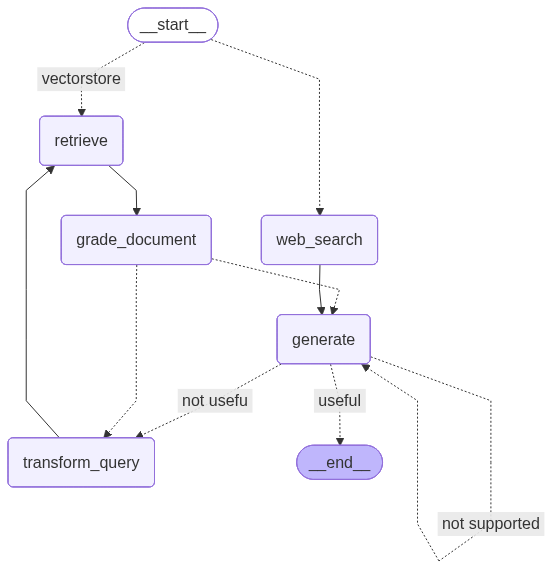

In [33]:
workflow = StateGraph(GraphState)

## define the nodes
workflow.add_node("web_search", web_search)
workflow.add_node("retrieve", retrieve)
workflow.add_node("grade_document", grade_document)
workflow.add_node("generate", generate)
workflow.add_node("transform_query", transform_query)


## Build graph
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "web_search": "web_search",
        "vectorstore": "retrieve",
    },
)
workflow.add_edge("web_search", "generate")
workflow.add_edge("retrieve", "grade_document")
workflow.add_conditional_edges(
    "grade_document", 
    decide_to_generate,
     {
          "transform_query": "transform_query",
          "generate": "generate"
     },
)
workflow.add_edge("transform_query", "retrieve")
workflow.add_conditional_edges(
    "generate", 
    grade_generation_v_documents_and_question,
     {
          "not supported": "generate",
          "useful": END,
          "not usefu": "transform_query"
     },
)


## Compile
app = workflow.compile()

# Display
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [34]:
app.invoke({"question": "what is machine learning"})

---- ROUTE QUESTION---
--- ROUTE QUESTION TO WEB SEARCH---
------ Web Search--------
-------- generate ---------
--- CHECK HALLUCINATION----
--- DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
--- GRADE GENERATION VS QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION ---


{'question': 'what is machine learning',
 'generation': '<think>\nOkay, I need to answer the question "What is machine learning?" using the provided context. Let me start by reading through the context carefully to extract the key points.\n\nThe context mentions that machine learning (ML) is a subfield of artificial intelligence (AI). It\'s defined as giving computers the ability to learn without explicit programming, a definition from Arthur Samuel in the 1950s. ML uses statistical algorithms to learn from data, generalize to unseen data, and perform tasks without explicit instructions. It\'s used in various applications like natural language processing, computer vision, etc. The context also clarifies that ML is a subset of AI, so while they are related, they are not the same. ML focuses on algorithms that learn patterns from data to make decisions or predictions, and it\'s closely tied to data science. The process involves training models on datasets so they can make accurate predic

In [35]:
app.invoke({"question": "what is agent memory"})

---- ROUTE QUESTION---
--- ROUTE TO RAG---
-------- Retrieve --------
------ Check documents relevance to question-----
----Grade: Document relevant----
----Grade: Document relevant----
----- Grade: Document not relevant----
----Grade: Document relevant----
--- Assess graded documents---
----Decision : Generate----
-------- generate ---------
--- CHECK HALLUCINATION----
--- DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
--- GRADE GENERATION VS QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION ---


{'question': 'what is agent memory',
 'generation': '<think>\nOkay, let\'s tackle this question about agent memory. The user wants to know what agent memory is, based on the provided context.\n\nFirst, I\'ll look through the documents to find relevant sections. The context mentions two types of memory: short-term and long-term. In the first document, under the "Memory" section, it says short-term memory involves in-context learning, like prompt engineering, while long-term memory uses external vector stores for infinite information retention. \n\nAnother part from the third document talks about retrieval models considering recency, importance, and relevance. There\'s also mention of reflection mechanisms that synthesize memories into higher-level inferences. \n\nWait, the second document discusses challenges like finite context length affecting memory. But the user specifically asked about agent memory, so focus on the components described. \n\nAgent memory seems to be split into short